In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
import seaborn as sns
import os
import sys
import pickle
from glob import glob

sys.path.append('../../benchmarks_known/')
from benchmark_functions import (
        # continuous
        DejongConstr, 
        BraninConstr, 
        HyperEllipsoidConstr, 
        StyblinskiTangConstr,
        AckleyPathConstr,
        SchwefelConstr,
        NarrowFunnelConstr,
        DiscreteAckleyConstr,
        RastriginConstr,
        # categorical
        CatDejongConstr,
        CatSlopeConstr,
        CatCamelConstr,
        CatMichalewiczConstr,
)


sns.set(style='ticks', context='notebook', font_scale=1.2)

## Helper functions

In [3]:
# Golem colormap
_reference_colors = ['#008080', '#70a494', '#b4c8a8', '#f6edbd', '#edbb8a', '#de8a5a','#ca562c']
_cmap = LinearSegmentedColormap.from_list('golem', _reference_colors)
_cmap_r = LinearSegmentedColormap.from_list('golem_r', _reference_colors[::-1])
plt.register_cmap(cmap=_cmap)
plt.register_cmap(cmap=_cmap_r)

def get_golem_colors(n):
    _cmap = plt.get_cmap('golem')
    return [_cmap(x) for x in np.linspace(0, 1, n)]

def plot_contour(ax, X0, X1, y, xlims, ylims, vlims=[None, None], alpha=0.5, contour_lines=True, contour_labels=True, 
                 labels_fs=8, labels_fmt='%d', n_contour_lines=8, contour_color='k', contour_alpha=1, cbar=False, cmap='golem'):
    # background surface
    if contour_lines is True:
        contours = ax.contour(X0, X1, y, n_contour_lines, colors=contour_color, alpha=contour_alpha, linestyles='dashed')
        if contour_labels is True:
            _ = ax.clabel(contours, inline=True, fontsize=labels_fs, fmt=labels_fmt)
    mappable = ax.imshow(y, extent=[xlims[0],xlims[1],ylims[0],ylims[1]], 
                         origin='lower', cmap=cmap, alpha=alpha, vmin=vlims[0], vmax=vlims[1])
    
    if cbar is True:
        cbar = plt.colorbar(mappable=mappable, ax=ax, shrink=0.5)
        
    return mappable

def plot_constr_surface(surface, ax=None, N=100):
    
    if ax is None:
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5))

    x0 = np.linspace(0,1,N)
    x1 = np.linspace(0,1,N)
    X0, X1 = np.meshgrid(x0,x1)
    X = np.array([X0.flatten(), X1.flatten()]).T
    print(X.shape)
    y = np.array(surface.run(X)).flatten()
    print(y.shape)
    Y = np.reshape(y, newshape=np.shape(X0))

    _ = plot_contour(ax, X0, X1, Y, xlims=[0,1], ylims=[0,1], alpha=1, contour_lines=True, contour_labels=True, 
                 labels_fs=8, labels_fmt='%d', n_contour_lines=8, contour_alpha=0.8, cbar=False, cmap='golem')
    for param in surface.minima:
        x_min = param['params']
        ax.scatter(x_min[0], x_min[1], s=200, marker='*', color='#ffc6ff', zorder=20)
    
    params = [{'x0':x[0], 'x1':x[1]} for x in X]
    y_feas = surface.eval_constr(params)
    Y_feas = np.reshape(y_feas, newshape=np.shape(X0))
    ax.imshow(Y_feas, extent=[0,1,0,1], origin='lower', cmap='gray', alpha=0.5, interpolation='nearest')

In [4]:
def get_traces_min(data, replace_nan=True):
    traces_min = []
    for df in data:
        trace = df.loc[:, 'obj'].to_numpy()
        #print(trace)
        # if first is nan, replace with first non-nan
        if replace_nan is True:
            if np.isnan(trace[0]):
                for val in trace[1:]:
                    if not np.isnan(val):
                        trace[0] = val
                        break
        trace_min = [np.nanmin(trace[:i+1]) for i in range(len(trace))]
        traces_min.append(trace_min)
    return np.array(traces_min)


def get_traces_min_for_categorical(data, replace_nan=True):
    traces_min = []
    for df in data:
        trace = np.zeros(100)  # up to 100
        results = df.loc[:, 'obj'].to_numpy()[:100]  # up to 100
        trace[:len(results)] = results
        
        # if first is nan, replace with first non-nan
        if replace_nan is True:
            if np.isnan(trace[0]):
                for val in trace[1:]:
                    if not np.isnan(val):
                        trace[0] = val
                        break
        trace_min = [np.nanmin(trace[:i+1]) for i in range(len(trace))]
        traces_min.append(trace_min)
    return np.array(traces_min)


def plot_min_trace_mean(data, ax=None, color=None, label=None, categorical=False, shift=0.0, log=False):
    
    if ax is None:
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,4))
        
    if categorical is True:
        traces_min = get_traces_min_for_categorical(data) - shift
    else:
        traces_min = get_traces_min(data) - shift
    
    if log is True:
        traces_min = np.log10(traces_min)
    
    mean = np.nanmean(traces_min, axis=0)
    stde = np.nanstd(traces_min, axis=0, ddof=1) / np.sqrt(np.shape(traces_min)[0] - 1)
    
    x = range(1, np.shape(traces_min)[1]+1, 1)

    ax.plot(x, mean, color='#444444', linewidth=5)
    ax.plot(x, mean, color=color, linewidth=4, label=label)
    
    ax.fill_between(x, y1=mean-1.96*stde, y2=mean+1.96*stde, alpha=0.2, color=color)
    ax.plot(x, mean-1.96*stde, color=color, linewidth=1, alpha=0.5)
    ax.plot(x, mean+1.96*stde, color=color, linewidth=1, alpha=0.5)
    
def plot_min_trace_median(data, ax=None, color=None, label=None, nboots=1000):
    
    if ax is None:
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,4))
        
    traces_min = get_traces_min(data, replace_nan=True)

    median = np.median(traces_min, axis=0)
    q100, q75, q25, q0 = bootstrapped_iqr(traces_min, nboots=1000)
    x = range(1, np.shape(traces_min)[1] + 1, 1)

    ax.plot(x, median, color=color, label=label)
    ax.fill_between(x, y1=q25, y2=q75, alpha=0.2, color=color)
    ax.fill_between(x, y1=q0, y2=q100, alpha=0.2, color=color)
    
    
def bootstrapped_iqr(traces, nboots=100):
    boot_medians = []
    for b in range(nboots):
        boot_idx = np.random.randint(low=0, high=traces.shape[0], size=traces.shape[0])
        boot_traces = traces[boot_idx]
        boot_median = np.median(boot_traces, axis=0)
        boot_medians.append(boot_median)
        
    q75, q25 = np.percentile(np.array(boot_medians), [75 ,25], axis=0)
    q100 = np.max(traces, axis=0)
    q0 = np.min(traces, axis=0)
    return q100, q75, q25, q0


def plot_trace_sigle(folder, ax, categorical=False, color='k', label='', shift=0.0, log=False):
    with open(f'{folder}/results.pkl', 'rb') as content:
        data = pickle.load(content)
    plot_min_trace_mean(data, ax=ax, color=color, label=label, categorical=categorical, shift=shift, log=log)
    
def plot_trace_sigle_dragonfly(folder, ax, categorical=False, color='k', label='', shift=0.0, log=False):
    with open(f'{folder}/results.pkl', 'rb') as content:
        data = pickle.load(content)
    reversed_frames = []
    for d in data:
        new_frame = d.copy()
        new_frame['obj'] = -1*d['obj']
        reversed_frames.append(new_frame)
    plot_min_trace_mean(reversed_frames, ax=ax, color=color, label=label, categorical=categorical, shift=shift, log=log)

## Plot most recent results 

(10000, 2)
(10000,)


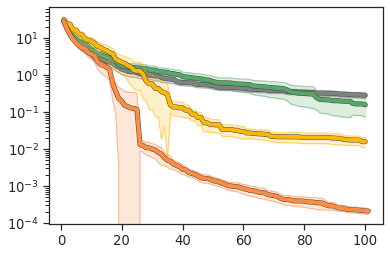

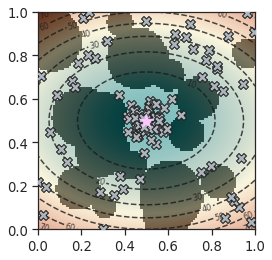

In [17]:
#-------------------------------------
# HyperEllips without sample selector
#-------------------------------------

fig, ax = plt.subplots()

surface = HyperEllipsoidConstr()
plot_trace_sigle('../../benchmarks_known/hyperellips/random/', ax, color='gray', label='Random',
                 shift=surface.minima[0]['value'], log=False)
plot_trace_sigle('../../benchmarks_known/hyperellips/deap/', ax, color='g', label='Genetic', 
                 shift=surface.minima[0]['value'], log=False)
# plot_trace_sigle('../../benchmarks_known/hyperellips/opt_adam_wo_ss/', ax, color='#219ebc', label='Gryffin (Adam)', 
#                  shift=surface.minima[0]['value'], log=False)
plot_trace_sigle('../../benchmarks_known/hyperellips/opt_genetic_wo_ss/', ax, color='#ffb703', label='Gryffin (Genetic)', 
                 shift=surface.minima[0]['value'], log=False)
plot_trace_sigle_dragonfly('../../benchmarks_known/hyperellips/dragonfly/', ax, color='#ff8c42', label='Dragonfly', 
                  shift=surface.minima[0]['value'], log=False)

ax.set_yscale('log')

fig, ax = plt.subplots()

plot_constr_surface(surface, ax=ax, N=100)
# example samples
with open('../../benchmarks_known/hyperellips/opt_adam/results.pkl', 'rb') as content:
#with open('../../benchmarks_known/ackleypath/dragonfly/results.pkl', 'rb') as content:
    data = pickle.load(content)
X = data[2].loc[:, ['x0', 'x1']]
ax.scatter(X['x0'], X['x1'], marker='X', s=100, color='#adb5bd', edgecolor='k', zorder=10)

(10000, 2)
(10000,)


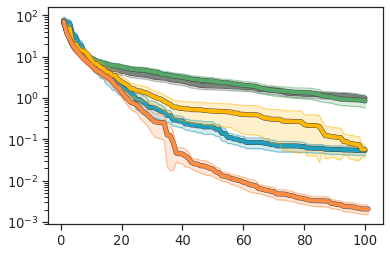

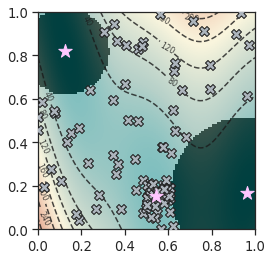

In [22]:
#-------------------------------------
# Branin without sample selector
#-------------------------------------

fig, ax = plt.subplots()

surface = BraninConstr()
plot_trace_sigle('../../benchmarks_known/branin/random/', ax, color='gray', label='Random',
                 shift=surface.minima[0]['value'], log=False)
plot_trace_sigle('../../benchmarks_known/branin/deap/', ax, color='g', label='Genetic', 
                 shift=surface.minima[0]['value'], log=False)
plot_trace_sigle('../../benchmarks_known/branin/opt_adam_wo_ss/', ax, color='#219ebc', label='Gryffin (Adam)', 
                 shift=surface.minima[0]['value'], log=False)
plot_trace_sigle('../../benchmarks_known/branin/opt_genetic_wo_ss/', ax, color='#ffb703', label='Gryffin (Genetic)', 
                 shift=surface.minima[0]['value'], log=False)
plot_trace_sigle_dragonfly('../../benchmarks_known/branin/dragonfly/', ax, color='#ff8c42', label='Dragonfly', 
                  shift=surface.minima[0]['value'], log=False)

ax.set_yscale('log')

fig, ax = plt.subplots()

plot_constr_surface(surface, ax=ax, N=100)
# example samples
with open('../../benchmarks_known/branin/opt_adam_wo_ss/results.pkl', 'rb') as content:
#with open('../../benchmarks_known/ackleypath/dragonfly/results.pkl', 'rb') as content:
    data = pickle.load(content)
X = data[2].loc[:, ['x0', 'x1']]
ax.scatter(X['x0'], X['x1'], marker='X', s=100, color='#adb5bd', edgecolor='k', zorder=10)

(10000, 2)
(10000,)


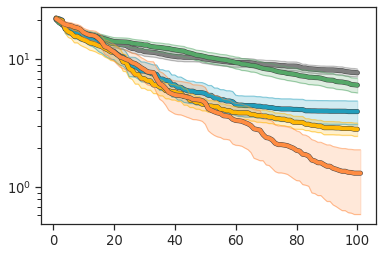

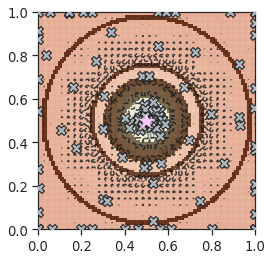

In [7]:
#--------------------
# AckleyPath regular
#--------------------

fig, ax = plt.subplots()

surface = AckleyPathConstr()
plot_trace_sigle('../../benchmarks_known/ackleypath/random/', ax, color='gray', label='Random',
                 shift=surface.minima[0]['value'], log=False)
plot_trace_sigle('../../benchmarks_known/ackleypath/deap/', ax, color='g', label='Genetic', 
                 shift=surface.minima[0]['value'], log=False)
plot_trace_sigle('../../benchmarks_known/ackleypath/opt_adam/', ax, color='#219ebc', label='Gryffin (Adam)', 
                 shift=surface.minima[0]['value'], log=False)
plot_trace_sigle('../../benchmarks_known/ackleypath/opt_genetic/', ax, color='#ffb703', label='Gryffin (Genetic)', 
                 shift=surface.minima[0]['value'], log=False)
plot_trace_sigle('../../benchmarks_known/ackleypath/dragonfly/', ax, color='#ff8c42', label='Dragonfly', 
                  shift=surface.minima[0]['value'], log=False)

ax.set_yscale('log')

fig, ax = plt.subplots()

plot_constr_surface(surface, ax=ax, N=100)
# example samples
with open('../../benchmarks_known/ackleypath/dragonfly/results.pkl', 'rb') as content:
#with open('../../benchmarks_known/ackleypath/dragonfly/results.pkl', 'rb') as content:
    data = pickle.load(content)
X = data[2].loc[:, ['x0', 'x1']]
ax.scatter(X['x0'], X['x1'], marker='X', s=100, color='#adb5bd', edgecolor='k', zorder=10)

list

(10000, 2)
(10000,)


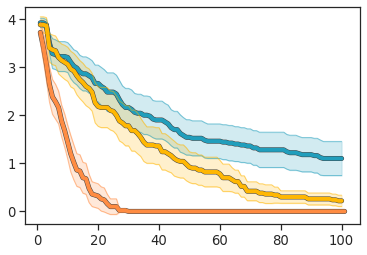

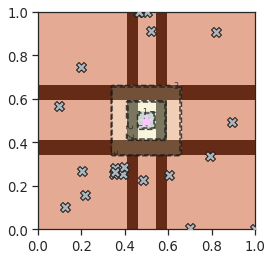

In [8]:
#--------------------
# Narrow regular
#--------------------

fig, ax = plt.subplots()

surface = NarrowFunnelConstr()
# plot_trace_sigle('../../benchmarks_known/narrow/random/', ax, color='gray', label='Random',
#                  shift=surface.minima[0]['value'], log=False)
# plot_trace_sigle('../../benchmarks_known/narrow/deap/', ax, color='g', label='Genetic', 
#                  shift=surface.minima[0]['value'], log=False)
plot_trace_sigle('../../benchmarks_known/narrow/opt_adam/', ax, color='#219ebc', label='Gryffin (Adam)', 
                 shift=surface.minima[0]['value'], log=False)
plot_trace_sigle('../../benchmarks_known/narrow/opt_genetic/', ax, color='#ffb703', label='Gryffin (Genetic)', 
                 shift=surface.minima[0]['value'], log=False)
plot_trace_sigle('../../benchmarks_known/narrow/dragonfly/', ax, color='#ff8c42', label='Dragonfly', 
                  shift=surface.minima[0]['value'], log=False)

#ax.set_yscale('log')

fig, ax = plt.subplots()

plot_constr_surface(surface, ax=ax, N=100)
# example samples
with open('../../benchmarks_known/narrow/dragonfly/results.pkl', 'rb') as content:
#with open('../../benchmarks_known/ackleypath/dragonfly/results.pkl', 'rb') as content:
    data = pickle.load(content)
X = data[2].loc[:20, ['x0', 'x1']]
ax.scatter(X['x0'], X['x1'], marker='X', s=100, color='#adb5bd', edgecolor='k', zorder=10)

(10000, 2)
(10000,)


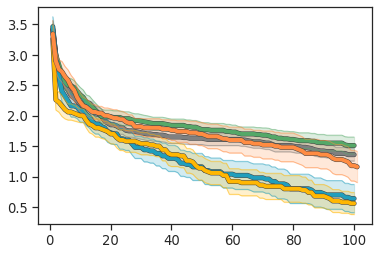

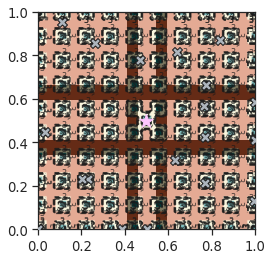

In [17]:
#--------------------
# DiscreteAckley regular
#--------------------

fig, ax = plt.subplots()

surface = DiscreteAckleyConstr()
plot_trace_sigle('../../benchmarks_known/discreteackley/random/', ax, color='gray', label='Random',
                 shift=surface.minima[0]['value'], log=False)
plot_trace_sigle('../../benchmarks_known/discreteackley/deap/', ax, color='g', label='Genetic', 
                 shift=surface.minima[0]['value'], log=False)
plot_trace_sigle('../../benchmarks_known/discreteackley/opt_adam/', ax, color='#219ebc', label='Gryffin (Adam)', 
                 shift=surface.minima[0]['value'], log=False)
plot_trace_sigle('../../benchmarks_known/discreteackley/opt_genetic/', ax, color='#ffb703', label='Gryffin (Genetic)', 
                 shift=surface.minima[0]['value'], log=False)
plot_trace_sigle('../../benchmarks_known/discreteackley/dragonfly/', ax, color='#ff8c42', label='Dragonfly', 
                  shift=surface.minima[0]['value'], log=False)

#ax.set_yscale('log')

fig, ax = plt.subplots()

plot_constr_surface(surface, ax=ax, N=100)
# example samples
with open('../../benchmarks_known/discreteackley/dragonfly/results.pkl', 'rb') as content:
#with open('../../benchmarks_known/ackleypath/dragonfly/results.pkl', 'rb') as content:
    data = pickle.load(content)
X = data[2].loc[:20, ['x0', 'x1']]
ax.scatter(X['x0'], X['x1'], marker='X', s=100, color='#adb5bd', edgecolor='k', zorder=10)

(10000, 2)
(10000,)


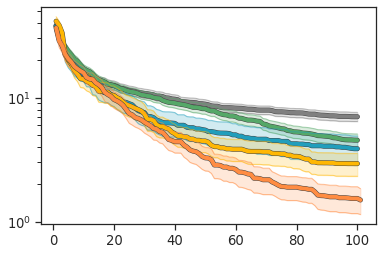

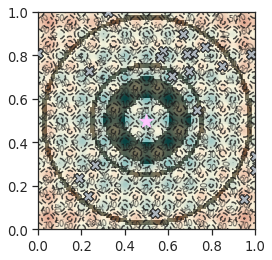

In [14]:
#--------------------
# Rastrigin regular
#--------------------

fig, ax = plt.subplots()

surface = RastriginConstr()
plot_trace_sigle('../../benchmarks_known/rastrigin/random/', ax, color='gray', label='Random',
                 shift=surface.minima[0]['value'], log=False)
plot_trace_sigle('../../benchmarks_known/rastrigin/deap/', ax, color='g', label='Genetic', 
                 shift=surface.minima[0]['value'], log=False)
plot_trace_sigle('../../benchmarks_known/rastrigin/opt_adam/', ax, color='#219ebc', label='Gryffin (Adam)', 
                 shift=surface.minima[0]['value'], log=False)
plot_trace_sigle('../../benchmarks_known/rastrigin/opt_genetic/', ax, color='#ffb703', label='Gryffin (Genetic)', 
                 shift=surface.minima[0]['value'], log=False)
plot_trace_sigle('../../benchmarks_known/rastrigin/dragonfly/', ax, color='#ff8c42', label='Dragonfly', 
                  shift=surface.minima[0]['value'], log=False)

ax.set_yscale('log')

fig, ax = plt.subplots()

plot_constr_surface(surface, ax=ax, N=100)
# example samples
with open('../../benchmarks_known/rastrigin/dragonfly/results.pkl', 'rb') as content:
#with open('../../benchmarks_known/ackleypath/dragonfly/results.pkl', 'rb') as content:
    data = pickle.load(content)
X = data[2].loc[:20, ['x0', 'x1']]
ax.scatter(X['x0'], X['x1'], marker='X', s=100, color='#adb5bd', edgecolor='k', zorder=10)

In [9]:
surface = NarrowFunnelConstr()
#surface = AckleyPathConstr()

In [10]:
surface.run([0.1, 0.2])

[[4], [4]]

(10000, 2)
(10000,)


FileNotFoundError: [Errno 2] No such file or directory: '../../benchmarks_known/ackleypath/dragonfly/results.pkl'

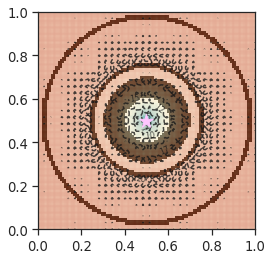

In [84]:
fig, ax = plt.subplots()

plot_constr_surface(surface, ax=ax, N=100)
# example samples
with open('../../benchmarks_known/ackleypath/dragonfly/results.pkl', 'rb') as content:
    data = pickle.load(content)
X = data[0].loc[:, ['x0', 'x1']]
ax.scatter(X['x0'], X['x1'], marker='X', s=100, color='#adb5bd', edgecolor='k', zorder=10)

In [99]:
1 / 100**5

1e-10

(10000, 2)
(10000,)


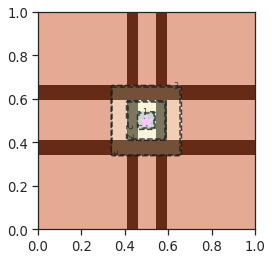

In [13]:
fig, ax = plt.subplots()
surface = NarrowFunnelConstr()
plot_constr_surface(surface, ax=ax, N=100)

In [14]:
X = np.array([[0.2, 0.5], [0.5, 0.5], [0.55, 0.5]])
y = surface.run(X)
print(y)

[[4], [0], [2]]


In [68]:
np.amax(X, axis=1)

array([0.2, 0.9])

In [69]:
np.abs(X)

array([[0.1, 0.2],
       [0.2, 0.9]])

In [93]:
(np.array([1, 4, 9, 16, 25]) + 50 ) /100

array([0.51, 0.54, 0.59, 0.66, 0.75])

(10000, 2)
(10000,)


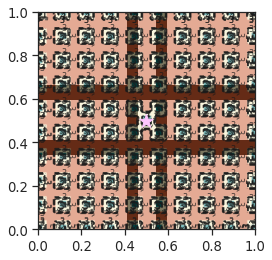

In [26]:
fig, ax = plt.subplots()
surface = DiscreteAckleyConstr()
plot_constr_surface(surface, ax=ax, N=100)

In [28]:
X = np.array([[0.2, 0.5], [0.5, 0.5], [0.55, 0.5]])
y = surface.run(X)
print(y)

[4, 2, 4]


(10000, 2)
(10000,)


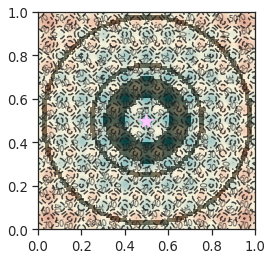

In [25]:
fig, ax = plt.subplots()
surface = RastriginConstr()
plot_constr_surface(surface, ax=ax, N=100)

(10000, 2)
(10000,)


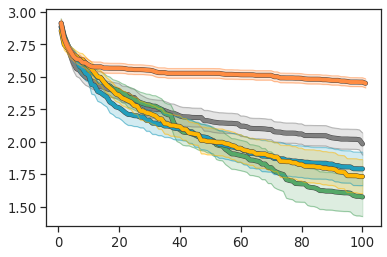

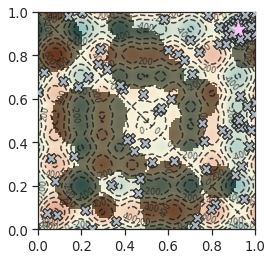

In [37]:
#--------------------
# Schwefel regular
#--------------------

fig, ax = plt.subplots()

surface = SchwefelConstr()
plot_trace_sigle('../../benchmarks_known/schwefel/random/', ax, color='gray', label='Random',
                 shift=surface.minima[0]['value'], log=True)
plot_trace_sigle('../../benchmarks_known/schwefel/deap/', ax, color='g', label='Genetic', 
                 shift=surface.minima[0]['value'], log=True)
plot_trace_sigle('../../benchmarks_known/schwefel/opt_adam/', ax, color='#219ebc', label='Gryffin (Adam)', 
                 shift=surface.minima[0]['value'], log=True)
plot_trace_sigle('../../benchmarks_known/schwefel/opt_genetic/', ax, color='#ffb703', label='Gryffin (Genetic)', 
                 shift=surface.minima[0]['value'], log=True)
plot_trace_sigle_dragonfly('../../benchmarks_known/schwefel/dragonfly/', ax, color='#ff8c42', label='Dragonfly', 
                  shift=surface.minima[0]['value'], log=True)


fig, ax = plt.subplots()

plot_constr_surface(surface, ax=ax, N=100)
# example samples
with open('../../benchmarks_known/schwefel/opt_genetic/results.pkl', 'rb') as content:
    data = pickle.load(content)
X = data[0].loc[:, ['x0', 'x1']]
ax.scatter(X['x0'], X['x1'], marker='X', s=100, color='#adb5bd', edgecolor='k', zorder=10)

In [35]:
 with open(f'../../benchmarks_known/schwefel/random/results.pkl', 'rb') as content:
        data = pickle.load(content)

In [36]:
data

[          x0        x1         obj
 0   0.828738  0.356753  135.754768
 1   0.706857  0.729007 -325.199810
 2   0.771270  0.074045  603.183393
 3   0.358466  0.115869  173.913788
 4   0.863103  0.623298   48.403690
 ..       ...       ...         ...
 95  0.750615  0.806835  328.901348
 96  0.990505  0.412618   83.022152
 97  0.858413  0.428994   30.241869
 98  0.750871  0.754543   94.852596
 99  0.320050  0.895523 -205.764079
 
 [100 rows x 3 columns],
           x0        x1         obj
 0   0.389202  0.010838 -160.216175
 1   0.905382  0.091287   11.377207
 2   0.950607  0.573438 -367.042655
 3   0.672518  0.752375  -48.073791
 4   0.791579  0.789618  565.427660
 ..       ...       ...         ...
 95  0.498368  0.418925   34.668727
 96  0.914846  0.362394 -516.353957
 97  0.580588  0.632264   80.866871
 98  0.013094  0.663537  -72.356921
 99  0.178036  0.961070 -481.975531
 
 [100 rows x 3 columns],
           x0        x1         obj
 0   0.502195  0.595385   29.780480
 1   0.209

## Plot continuous results

Surfaces = {Branin, Styblinski-Tang, Dejong, Hyperellips}

Strategies = {RandomSearch, Genetic, Gryffin (Adam), Gryffin (Genetic), Dragonfly}



(10000, 2)
(10000,)
(10000, 2)
(10000,)
(10000, 2)
(10000,)
(10000, 2)
(10000,)


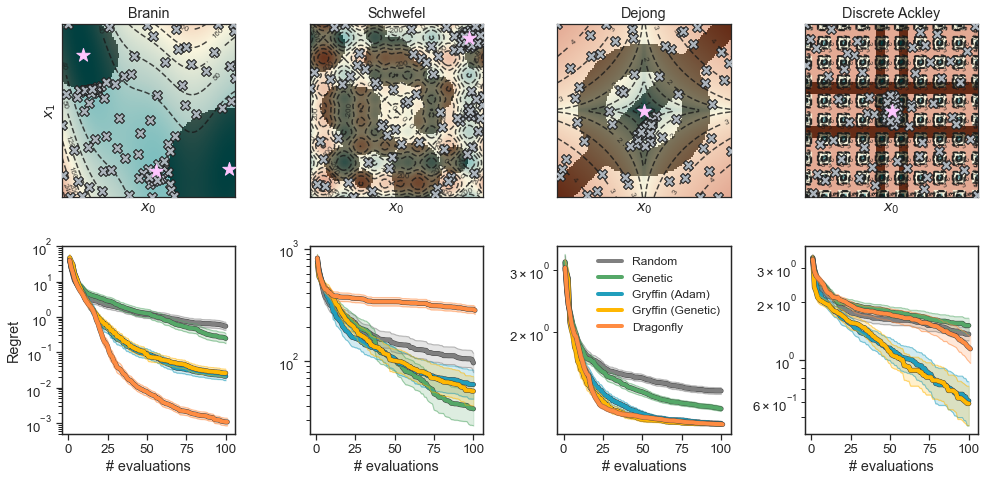

In [5]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(14, 7))


# -------------
# Plot surfaces
# -------------
ax = axes[0,0]
surface = BraninConstr()
plot_constr_surface(surface, ax=ax, N=100)
# example samples
with open('../../benchmarks_known/branin/opt_genetic/results.pkl', 'rb') as content:
    data = pickle.load(content)
X = data[0].loc[:, ['x0', 'x1']]
ax.scatter(X['x0'], X['x1'], marker='X', s=100, color='#adb5bd', edgecolor='k', zorder=10)


# ax = axes[0,1]
# surface = StyblinskiTangConstr()
# plot_constr_surface(surface, ax=ax, N=100)
# # example samples
# with open('../../benchmarks_known/styblinski/opt_genetic/results.pkl', 'rb') as content:
#     data = pickle.load(content)
# X = data[0].loc[:, ['x0', 'x1']]
# ax.scatter(X['x0'], X['x1'], marker='X', s=100, color='#adb5bd', edgecolor='k', zorder=10)


ax = axes[0,1]
surface = SchwefelConstr()
plot_constr_surface(surface, ax=ax, N=100)
# example samples
with open('../../benchmarks_known/schwefel/opt_genetic/results.pkl', 'rb') as content:
    data = pickle.load(content)
X = data[0].loc[:, ['x0', 'x1']]
ax.scatter(X['x0'], X['x1'], marker='X', s=100, color='#adb5bd', edgecolor='k', zorder=10)


ax = axes[0,2]
surface = DejongConstr()
plot_constr_surface(surface, ax=ax, N=100)
# example samples
with open('../../benchmarks_known/dejong/opt_genetic/results.pkl', 'rb') as content:
    data = pickle.load(content)
X = data[0].loc[:, ['x0', 'x1']]
ax.scatter(X['x0'], X['x1'], marker='X', s=100, color='#adb5bd', edgecolor='k', zorder=10)


# ax = axes[0,3]
# surface = HyperEllipsoidConstr()
# plot_constr_surface(surface, ax=ax, N=100)
# # example samples
# with open('../../benchmarks_known/hyperellips/opt_genetic/results.pkl', 'rb') as content:
#     data = pickle.load(content)
# X = data[0].loc[:, ['x0', 'x1']]
# ax.scatter(X['x0'], X['x1'], marker='X', s=100, color='#adb5bd', edgecolor='k', zorder=10)

ax = axes[0,3]
surface = DiscreteAckleyConstr()
plot_constr_surface(surface, ax=ax, N=100)
# example samples
with open('../../benchmarks_known/discreteackley/opt_genetic/results.pkl', 'rb') as content:
    data = pickle.load(content)
X = data[0].loc[:, ['x0', 'x1']]
ax.scatter(X['x0'], X['x1'], marker='X', s=100, color='#adb5bd', edgecolor='k', zorder=10)

# -------------
# Plot traces
# -------------
log = True

ax = axes[1,0]  # the ax object
ax.set(yscale="log")  # set log scale for y
ax2 = ax.twinx()  # create a new axis for plotting the data already in logscale

surface = BraninConstr()
plot_trace_sigle('../../benchmarks_known/branin/random/', ax2, color='gray', label='Random',
                 shift=surface.minima[1]['value'], log=log)
plot_trace_sigle('../../benchmarks_known/branin/deap/', ax2, color='g', label='Genetic', 
                 shift=surface.minima[1]['value'], log=log)
plot_trace_sigle('../../benchmarks_known/branin/opt_adam/', ax2, color='#219ebc', label='Gryffin (Adam)', 
                 shift=surface.minima[1]['value'], log=log)
plot_trace_sigle('../../benchmarks_known/branin/opt_genetic/', ax2, color='#ffb703', label='Gryffin (Genetic)', 
                 shift=surface.minima[1]['value'], log=log)
plot_trace_sigle_dragonfly('../../benchmarks_known/branin/dragonfly/', ax2, color='#ff8c42', label='Dragonfly', 
                  shift=surface.minima[1]['value'], log=log)
#axes[1,0].set_yscale('log')
# set the limits of the log log axis to 10 to the power of the label of ax2
ax.set_ylim(10**np.array(ax2.get_ylim()))
ax2.set_yticklabels([]) # remove ticklabels and axislabel from ax2
ax2.set_yticks([])

   
ax = axes[1,1]  # the ax object
ax.set(yscale="log")  # set log scale for y
ax2 = ax.twinx()  # create a new axis for plotting the data already in logscale

surface = SchwefelConstr()
plot_trace_sigle('../../benchmarks_known/schwefel/random/', ax2, color='gray', label='Random', 
                 shift=surface.minima[0]['value'], log=log)
plot_trace_sigle('../../benchmarks_known/schwefel/deap/', ax2, color='g', label='Genetic', 
                 shift=surface.minima[0]['value'], log=log)
plot_trace_sigle('../../benchmarks_known/schwefel/opt_adam/', ax2, color='#219ebc', label='Gryffin (Adam, prior)', 
                 shift=surface.minima[0]['value'], log=log)
plot_trace_sigle('../../benchmarks_known/schwefel/opt_genetic/', ax2, color='#ffb703', label='Gryffin (Genetic, prior)', 
                 shift=surface.minima[0]['value'], log=log)
plot_trace_sigle_dragonfly('../../benchmarks_known/schwefel/dragonfly/', ax2, color='#ff8c42', label='Dragonfly', 
                 shift=surface.minima[0]['value'], log=log)
#axes[1,1].set_yscale('log')
# set the limits of the log log axis to 10 to the power of the label of ax2
ax.set_ylim(10**np.array(ax2.get_ylim()))
ax2.set_yticklabels([]) # remove ticklabels and axislabel from ax2
ax2.set_yticks([])


ax = axes[1,2]  # the ax object
ax.set(yscale="log")  # set log scale for y
ax2 = ax.twinx()  # create a new axis for plotting the data already in logscale

surface = DejongConstr()
plot_trace_sigle('../../benchmarks_known/dejong/random/', ax2, color='gray', label='Random', 
                 shift=surface.minima[0]['value'], log=log)
plot_trace_sigle('../../benchmarks_known/dejong/deap/', ax2, color='g', label='Genetic', 
                 shift=surface.minima[0]['value'], log=log)
plot_trace_sigle('../../benchmarks_known/dejong/opt_adam/', ax2, color='#219ebc', label='Gryffin (Adam)', 
                 shift=surface.minima[0]['value'], log=log)
plot_trace_sigle('../../benchmarks_known/dejong/opt_genetic/', ax2, color='#ffb703', label='Gryffin (Genetic)', 
                 shift=surface.minima[0]['value'], log=log)
plot_trace_sigle_dragonfly('../../benchmarks_known/dejong/dragonfly/', ax2, color='#ff8c42', label='Dragonfly', 
                 shift=surface.minima[0]['value'], log=log)
#axes[1,2].set_yscale('log')
# set the limits of the log log axis to 10 to the power of the label of ax2
ax.set_ylim(10**np.array(ax2.get_ylim()))
ax2.set_yticklabels([]) # remove ticklabels and axislabel from ax2
ax2.set_yticks([])

# legend
ax2.legend(frameon=False, fontsize=12, loc='upper right')


ax = axes[1,3]  # the ax object
ax.set(yscale="log")  # set log scale for y
ax2 = ax.twinx()  # create a new axis for plotting the data already in logscale

surface = DiscreteAckleyConstr()
plot_trace_sigle('../../benchmarks_known/discreteackley/random/', ax, color='gray', label='Random',
                 shift=surface.minima[0]['value'], log=False)
plot_trace_sigle('../../benchmarks_known/discreteackley/deap/', ax, color='g', label='Genetic', 
                 shift=surface.minima[0]['value'], log=False)
plot_trace_sigle('../../benchmarks_known/discreteackley/opt_adam/', ax, color='#219ebc', label='Gryffin (Adam)', 
                 shift=surface.minima[0]['value'], log=False)
plot_trace_sigle('../../benchmarks_known/discreteackley/opt_genetic/', ax, color='#ffb703', label='Gryffin (Genetic)', 
                 shift=surface.minima[0]['value'], log=False)
plot_trace_sigle('../../benchmarks_known/discreteackley/dragonfly/', ax, color='#ff8c42', label='Dragonfly', 
                  shift=surface.minima[0]['value'], log=False)
#axes[1,3].set_yscale('log')
# set the limits of the log log axis to 10 to the power of the label of ax2
#ax.set_ylim(10**np.array(ax2.get_ylim()))
ax2.set_yticklabels([]) # remove ticklabels and axislabel from ax2
ax2.set_yticks([])


axes[1,0].set_ylabel('Regret')
for ax in axes[1,:]:
    ax.set_xlabel('# evaluations')
    ax.set_xticks([0,25,50,75,100])

axes[0,0].set_ylabel('$x_1$')
for ax in axes[0,:]:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('$x_0$')
    
    
axes[0,0].set_title('Branin')
axes[0,1].set_title('Schwefel')
axes[0,2].set_title('Dejong')
axes[0,3].set_title('Discrete Ackley')

#axes[1,0].legend(frameon=False)
#axes[1,1].legend(frameon=False, fontsize=12)
#axes[1,2].legend(frameon=False, fontsize=12, loc='upper right')
#axes[1,3].legend(frameon=False, fontsize=12)

#handles, labels = axes[1,0].get_legend_handles_labels()
#fig.legend(handles, labels, loc='lower center', ncol=4, frameon=False, bbox_to_anchor=(0.5, 0.48))
    
plt.tight_layout()
fig.savefig('kwn-continuous-log-new.pdf', bbox_inches="tight")
fig.savefig('kwn-continuous-log-new.png', dpi=300, bbox_inches="tight")

(10000, 2)
(10000,)
(10000, 2)
(10000,)
(10000, 2)
(10000,)
(10000, 2)
(10000,)


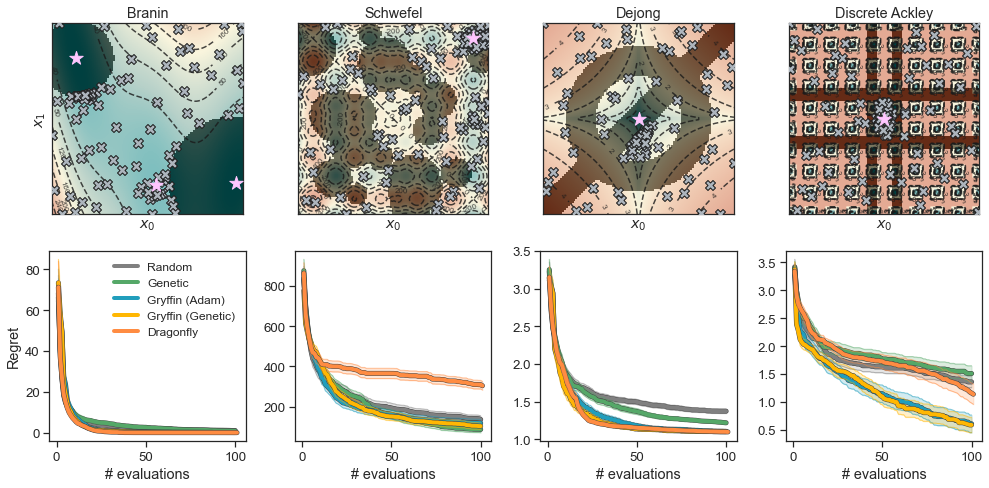

In [6]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(14, 7))


# -------------
# Plot surfaces
# -------------
ax = axes[0,0]
surface = BraninConstr()
plot_constr_surface(surface, ax=ax, N=100)
# example samples
with open('../../benchmarks_known/branin/opt_genetic/results.pkl', 'rb') as content:
    data = pickle.load(content)
X = data[0].loc[:, ['x0', 'x1']]
ax.scatter(X['x0'], X['x1'], marker='X', s=100, color='#adb5bd', edgecolor='k', zorder=10)


# ax = axes[0,1]
# surface = StyblinskiTangConstr()
# plot_constr_surface(surface, ax=ax, N=100)
# # example samples
# with open('../../benchmarks_known/styblinski/opt_genetic_prior/results.pkl', 'rb') as content:
#     data = pickle.load(content)
# X = data[0].loc[:, ['x0', 'x1']]
# ax.scatter(X['x0'], X['x1'], marker='X', s=100, color='#adb5bd', edgecolor='k', zorder=10)

ax = axes[0,1]
surface = SchwefelConstr()
plot_constr_surface(surface, ax=ax, N=100)
# example samples
with open('../../benchmarks_known/schwefel/opt_genetic/results.pkl', 'rb') as content:
    data = pickle.load(content)
X = data[0].loc[:, ['x0', 'x1']]
ax.scatter(X['x0'], X['x1'], marker='X', s=100, color='#adb5bd', edgecolor='k', zorder=10)


ax = axes[0,2]
surface = DejongConstr()
plot_constr_surface(surface, ax=ax, N=100)
# example samples
with open('../../benchmarks_known/dejong/opt_genetic/results.pkl', 'rb') as content:
    data = pickle.load(content)
X = data[0].loc[:, ['x0', 'x1']]
ax.scatter(X['x0'], X['x1'], marker='X', s=100, color='#adb5bd', edgecolor='k', zorder=10)


# ax = axes[0,3]
# surface = HyperEllipsoidConstr()
# plot_constr_surface(surface, ax=ax, N=100)
# # example samples
# with open('../../benchmarks_known/hyperellips/opt_genetic_prior/results.pkl', 'rb') as content:
#     data = pickle.load(content)
# X = data[0].loc[:, ['x0', 'x1']]
# ax.scatter(X['x0'], X['x1'], marker='X', s=100, color='#adb5bd', edgecolor='k', zorder=10)

ax = axes[0,3]
surface = DiscreteAckleyConstr()
plot_constr_surface(surface, ax=ax, N=100)
# example samples
with open('../../benchmarks_known/discreteackley/opt_genetic/results.pkl', 'rb') as content:
    data = pickle.load(content)
X = data[0].loc[:, ['x0', 'x1']]
ax.scatter(X['x0'], X['x1'], marker='X', s=100, color='#adb5bd', edgecolor='k', zorder=10)


# -------------
# Plot traces
# -------------
log = False

ax = axes[1,0]

surface = BraninConstr()
plot_trace_sigle('../../benchmarks_known/branin/random/', ax, color='gray', label='Random',
                 shift=surface.minima[1]['value'], log=log)
plot_trace_sigle('../../benchmarks_known/branin/deap/', ax, color='g', label='Genetic', 
                 shift=surface.minima[1]['value'], log=log)
plot_trace_sigle('../../benchmarks_known/branin/opt_adam/', ax, color='#219ebc', label='Gryffin (Adam)', 
                 shift=surface.minima[1]['value'], log=log)
plot_trace_sigle('../../benchmarks_known/branin/opt_genetic/', ax, color='#ffb703', label='Gryffin (Genetic)', 
                 shift=surface.minima[1]['value'], log=log)
plot_trace_sigle_dragonfly('../../benchmarks_known/branin/dragonfly/', ax, color='#ff8c42', label='Dragonfly', 
                  shift=surface.minima[1]['value'], log=log)
   
ax = axes[1,1]

surface = SchwefelConstr()
plot_trace_sigle('../../benchmarks_known/schwefel/random/', ax, color='gray', label='Random', 
                 shift=surface.minima[0]['value'], log=log)
plot_trace_sigle('../../benchmarks_known/schwefel/deap/', ax, color='g', label='Genetic', 
                 shift=surface.minima[0]['value'], log=log)
plot_trace_sigle('../../benchmarks_known/schwefel/opt_adam/', ax, color='#219ebc', label='Gryffin (Adam, prior)', 
                 shift=surface.minima[0]['value'], log=log)
plot_trace_sigle('../../benchmarks_known/schwefel/opt_genetic/', ax, color='#ffb703', label='Gryffin (Genetic, prior)', 
                 shift=surface.minima[0]['value'], log=log)
plot_trace_sigle_dragonfly('../../benchmarks_known/schwefel/dragonfly/', ax, color='#ff8c42', label='Dragonfly', 
                 shift=surface.minima[0]['value'], log=log)


ax = axes[1,2] 


surface = DejongConstr()
plot_trace_sigle('../../benchmarks_known/dejong/random/', ax, color='gray', label='Random', 
                 shift=surface.minima[0]['value'], log=log)
plot_trace_sigle('../../benchmarks_known/dejong/deap/', ax, color='g', label='Genetic', 
                 shift=surface.minima[0]['value'], log=log)
plot_trace_sigle('../../benchmarks_known/dejong/opt_adam/', ax, color='#219ebc', label='Gryffin (Adam)', 
                 shift=surface.minima[0]['value'], log=log)
plot_trace_sigle('../../benchmarks_known/dejong/opt_genetic/', ax, color='#ffb703', label='Gryffin (Genetic)', 
                 shift=surface.minima[0]['value'], log=log)
plot_trace_sigle_dragonfly('../../benchmarks_known/dejong/dragonfly/', ax, color='#ff8c42', label='Dragonfly', 
                 shift=surface.minima[0]['value'], log=log)

ax = axes[1,3]

surface = DiscreteAckleyConstr()
plot_trace_sigle('../../benchmarks_known/discreteackley/random/', ax, color='gray', label='Random',
                 shift=surface.minima[0]['value'], log=False)
plot_trace_sigle('../../benchmarks_known/discreteackley/deap/', ax, color='g', label='Genetic', 
                 shift=surface.minima[0]['value'], log=False)
plot_trace_sigle('../../benchmarks_known/discreteackley/opt_adam/', ax, color='#219ebc', label='Gryffin (Adam)', 
                 shift=surface.minima[0]['value'], log=False)
plot_trace_sigle('../../benchmarks_known/discreteackley/opt_genetic/', ax, color='#ffb703', label='Gryffin (Genetic)', 
                 shift=surface.minima[0]['value'], log=False)
plot_trace_sigle('../../benchmarks_known/discreteackley/dragonfly/', ax, color='#ff8c42', label='Dragonfly', 
                  shift=surface.minima[0]['value'], log=False)


axes[1,0].set_ylabel('Regret')
for ax in axes[1,:]:
    ax.set_xlabel('# evaluations')

axes[0,0].set_ylabel('$x_1$')
for ax in axes[0,:]:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('$x_0$')
    
    
axes[0,0].set_title('Branin')
axes[0,1].set_title('Schwefel')
axes[0,2].set_title('Dejong')
axes[0,3].set_title('Discrete Ackley')

#axes[1,0].legend(frameon=False)
#axes[1,1].legend(frameon=False, fontsize=12)
axes[1,0].legend(frameon=False, fontsize=12, loc='upper right')
#axes[1,3].legend(frameon=False, fontsize=12)

#handles, labels = axes[1,0].get_legend_handles_labels()
#fig.legend(handles, labels, loc='lower center', ncol=4, frameon=False, bbox_to_anchor=(0.5, 0.48))
    
plt.tight_layout()
fig.savefig('kwn-continuous-linear-new.pdf', bbox_inches="tight")
fig.savefig('kwn-continuous-linear-new.png', dpi=300, bbox_inches="tight")

## Plot categorical results

Surfaces = {CatSlope, CatDejong, CatCamel, CatMichalewicz}

Strategies = {RandomSearch, Genetic, Naive Gryffin (Adam), Naive Gryffin (Genetic), Static Gryffin (Adam), 
              Static Gryffin (Genetic), Dragonfly}

In [9]:
# helper functions
def plot_constr_surface_cat(surface, ax=None, mark_min=False):
    if ax is None:
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5))
    domain = np.arange(surface.num_opts)
    Z = np.zeros((surface.num_opts, surface.num_opts))
    Z_feas = np.empty((surface.num_opts, surface.num_opts))
    X = []
    for x_index, x in enumerate(domain):
        for y_index, y in enumerate(domain):
            x = ['x_{}'.format(x_index), 'x_{}'.format(y_index)]
            X.append(x)
            loss_value = surface.run(x)
            feas_bool = surface.eval_constr({'x0': x[0], 'x1': x[1]})
            Z[y_index, x_index] = loss_value
            Z_feas[y_index, x_index] = feas_bool
            
    # scale Camel for visualization 
    if type(surface).__name__ == 'CatCamelConstr':
        Z = np.log(Z)

    ax.imshow(Z, origin='lower', cmap = plt.get_cmap('golem'))
    ax.imshow(Z_feas, origin='lower', cmap='gray', alpha=0.5, interpolation='none')
    
    if mark_min is True:
        X_best = surface.str2array(surface.best)
        _ = ax.scatter(X_best[0], X_best[1], marker='*', s=200, color='#ffc6ff', linewidth=2, zorder=20)
        #_ = ax.scatter(X_best[0], X_best[1], marker='o', s=100, color='none', linewidth=2, edgecolor='#ec091f', zorder=20)
        #_ = ax.scatter(X_best[0], X_best[1], marker='s', s=70, color='none', linewidth=3, edgecolor='#ffc6ff', zorder=20)
        #_ = ax.scatter(X_best[0], X_best[1], marker='*', s=300, color='none', linewidth=3, edgecolor='#ffc6ff', zorder=1)
        
        
def unpack_dragonfly(path, best_params):
    all_evals = []
    for i in range(5):
        data_dragon = pickle.load(open(f'{path}/dragonfly_discrete/dragonfly_{i}/results.pkl', 'rb'))
        for run in data_dragon: 
            num_eval = 1
            for ix, row in run.iterrows():
                
                #param = (row['x0'], row['x1'])
                param = (f'x_{int(row["x0"])}', f'x_{int(row["x1"])}')
                if param == best_params:
                    break
                else:
                    num_eval+=1
            all_evals.append(num_eval)
            
    return np.array(all_evals)

def plot_cat_scatter(data, ax, n=0):
    X_str = data[n].loc[:, ['x0', 'x1']][:-1]  # remove last datapoint
    X_flt = pd.DataFrame([surface.str2array(x) for x in X_str.to_numpy()], columns=X_str.columns)
    ax.scatter(X_flt['x0'], X_flt['x1'], marker='X', s=100, color='#adb5bd', edgecolor='k', zorder=10)

In [17]:
def plot_eval_comparison(folder, ax, best_params, log=False):  
    
    num_evals_all = []
    opt_strategies = []

    with open(f'{folder}/random/results.pkl', 'rb') as content:
        data_random = pickle.load(content)
    with open(f'{folder}/deap/results.pkl', 'rb') as content:
        data_deap = pickle.load(content)

    # naive 
    with open(f'{folder}/opt_adam_prior_naive/results.pkl', 'rb') as content:
        data_naive_adam = pickle.load(content)
    with open(f'{folder}/opt_genetic_prior_naive/results.pkl', 'rb') as content:
        data_naive_gene = pickle.load(content)
        
    # static
    with open(f'{folder}/opt_adam_prior/results.pkl', 'rb') as content:
        data_prior_adam = pickle.load(content)
    with open(f'{folder}/opt_genetic_prior/results.pkl', 'rb') as content:
        data_prior_gene = pickle.load(content)
        
    
    if len(data_prior_adam) != len(data_prior_gene):
        min_len = min(len(data_prior_adam), len(data_prior_gene))
        print(f"using only {min_len} repeats for {folder}")
        data_prior_adam = data_prior_adam[:min_len]
        data_prior_gene = data_prior_gene[:min_len]
    
        

    num_evals = np.array([len(df) for df in data_random])
    num_evals_all.extend(num_evals)
    opt_strategies.extend(['random'] * len(num_evals))
    
    num_evals = np.array([len(df) for df in data_deap])
    num_evals_all.extend(num_evals)
    opt_strategies.extend(['deap'] * len(num_evals))
    
    # naive
#     num_evals = np.array([len(df) for df in data_naive_adam])
#     num_evals_all.extend(num_evals)
#     opt_strategies.extend(['adam_naive'] * len(num_evals))
    
#     num_evals = np.array([len(df) for df in data_naive_gene])
#     num_evals_all.extend(num_evals)
#     opt_strategies.extend(['genetic_naive'] * len(num_evals))
    
    # static
    num_evals = np.array([len(df) for df in data_prior_adam])
    num_evals_all.extend(num_evals)
    opt_strategies.extend(['adam'] * len(num_evals))

    num_evals = np.array([len(df) for df in data_prior_gene])
    num_evals_all.extend(num_evals)
    opt_strategies.extend(['genetic'] * len(num_evals))

    
    # dragonfly
    num_evals = unpack_dragonfly(path=folder, best_params=best_params)
    num_evals_all.extend(num_evals)
    opt_strategies.extend(['dragonfly']*len(num_evals))


    # create dataframe
    df = pd.DataFrame({'num_evals':num_evals_all, 'opt_strategy':opt_strategies})  

    # plot
    b_ = sns.boxplot(
                    ax=ax, data=df, x="opt_strategy", y="num_evals", showfliers=False, 
                    palette=['gray', 'g', '#219ebc', '#ffb703', 
                            '#ff8c42', ])
    s_ = sns.stripplot(
                ax=ax, data=df, x="opt_strategy", y="num_evals", 
                palette=['gray', 'g', '#219ebc', '#ffb703', '#ff8c42'], 
                      edgecolor='#444444', linewidth=1, size=6)
    # b_.set_xticklabels(rotation=30)
    if log:
        ax.set_yscale('log')
    return df
    
    
    
def plot_eval_comparison_si(folder, ax, best_params):  
    
    num_evals_all = []
    opt_strategies = []

    with open(f'{folder}/random/results.pkl', 'rb') as content:
        data_random = pickle.load(content)
    with open(f'{folder}/deap/results.pkl', 'rb') as content:
        data_deap = pickle.load(content)

    # naive 
    with open(f'{folder}/opt_adam_prior_naive/results.pkl', 'rb') as content:
        data_naive_adam = pickle.load(content)
    with open(f'{folder}/opt_genetic_prior_naive/results.pkl', 'rb') as content:
        data_naive_gene = pickle.load(content)
        
    # static
    with open(f'{folder}/opt_adam_prior/results.pkl', 'rb') as content:
        data_prior_adam = pickle.load(content)
    with open(f'{folder}/opt_genetic_prior/results.pkl', 'rb') as content:
        data_prior_gene = pickle.load(content)
        
    
    if len(data_prior_adam) != len(data_prior_gene):
        min_len = min(len(data_prior_adam), len(data_prior_gene))
        print(f"using only {min_len} repeats for {folder}")
        data_prior_adam = data_prior_adam[:min_len]
        data_prior_gene = data_prior_gene[:min_len]
    
        

    num_evals = np.array([len(df) for df in data_random])
    num_evals_all.extend(num_evals)
    opt_strategies.extend(['random'] * len(num_evals))
    
    num_evals = np.array([len(df) for df in data_deap])
    num_evals_all.extend(num_evals)
    opt_strategies.extend(['deap'] * len(num_evals))
    
    # naive
    num_evals = np.array([len(df) for df in data_naive_adam])
    num_evals_all.extend(num_evals)
    opt_strategies.extend(['adam_naive'] * len(num_evals))
    
    num_evals = np.array([len(df) for df in data_naive_gene])
    num_evals_all.extend(num_evals)
    opt_strategies.extend(['genetic_naive'] * len(num_evals))
    
    # static
    num_evals = np.array([len(df) for df in data_prior_adam])
    num_evals_all.extend(num_evals)
    opt_strategies.extend(['adam'] * len(num_evals))

    num_evals = np.array([len(df) for df in data_prior_gene])
    num_evals_all.extend(num_evals)
    opt_strategies.extend(['genetic'] * len(num_evals))

    
    # dragonfly
    num_evals = unpack_dragonfly(path=folder, best_params=best_params)
    num_evals_all.extend(num_evals)
    opt_strategies.extend(['dragonfly']*len(num_evals))


    # create dataframe
    df = pd.DataFrame({'num_evals':num_evals_all, 'opt_strategy':opt_strategies})  
    
    print('FOLDER : ', folder)
    drag_evals = df[df['opt_strategy']=='dragonfly']['num_evals']
    
    print(np.mean(drag_evals))
    print(np.std(drag_evals)/np.sqrt(len(drag_evals)))

    # plot
    b_ = sns.boxplot(
                    ax=ax, data=df, x="opt_strategy", y="num_evals", showfliers=False, 
                    palette=['gray', 'g', '#219ebc', '#ffb703', 
                            '#29527a', '#ccb800', '#ff8c42', 
                             '#508ca4', '#004f2d', '#ccb800',])
    s_ = sns.stripplot(
                ax=ax, data=df, x="opt_strategy", y="num_evals", 
                palette=['gray', 'g', '#219ebc', '#ffb703',
                         '#29527a','#ccb800', '#ff8c42',
                         '#508ca4', '#004f2d', '#ccb800'], 
                      edgecolor='#444444', linewidth=1, size=6)
    # b_.set_xticklabels(rotation=30)
    return df

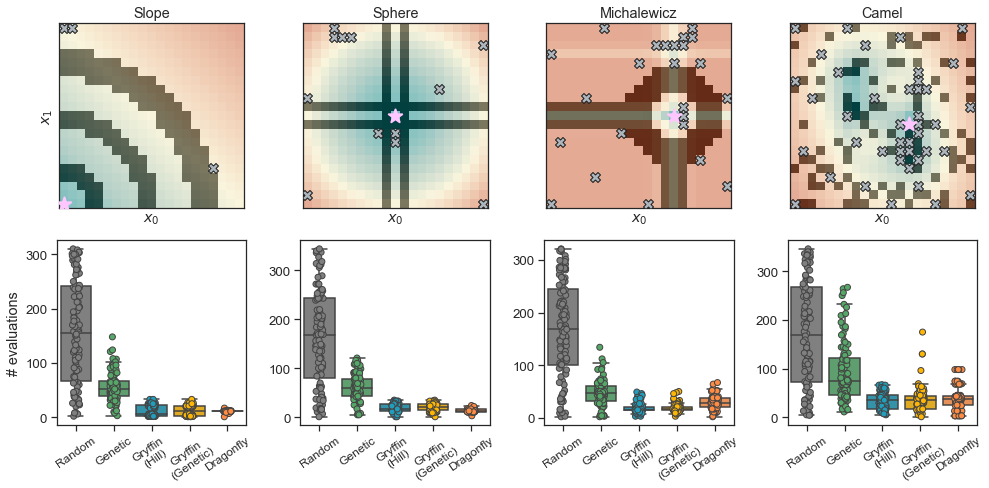

In [18]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(14, 7))

# -------------
# Plot surfaces
# -------------
ax = axes[0,0]
surface = CatSlopeConstr()
plot_constr_surface_cat(surface, ax=ax, mark_min=True)
# example samples
with open('../../benchmarks_known/cat-slope/opt_adam_prior/results.pkl', 'rb') as content:
    data = pickle.load(content)
plot_cat_scatter(data, ax=ax, n=3)


ax = axes[0,1]
surface = CatDejongConstr()
plot_constr_surface_cat(surface, ax=ax, mark_min=True)
# example samples
with open('../../benchmarks_known/cat-dejong/opt_adam_prior/results.pkl', 'rb') as content:
    data = pickle.load(content)
plot_cat_scatter(data, ax=ax, n=3)


ax = axes[0,2]
surface = CatMichalewiczConstr()
plot_constr_surface_cat(surface, ax=ax, mark_min=True)
# example samples
with open('../../benchmarks_known/cat-michalewicz/opt_adam_prior/results.pkl', 'rb') as content:
    data = pickle.load(content)
plot_cat_scatter(data, ax=ax, n=8)


ax = axes[0,3]
surface = CatCamelConstr()
plot_constr_surface_cat(surface, ax=ax, mark_min=True)
# example samples
with open('../../benchmarks_known/cat-camel/opt_adam_prior/results.pkl', 'rb') as content:
    data = pickle.load(content)
plot_cat_scatter(data, ax=ax, n=0)


# -------------
# Plot boxplots
# -------------
df_slope  = plot_eval_comparison('../../benchmarks_known/cat-slope/', ax=axes[1,0], best_params=CatSlopeConstr().best)
df_dejong = plot_eval_comparison('../../benchmarks_known/cat-dejong/', ax=axes[1,1], best_params=CatDejongConstr().best)
df_michal = plot_eval_comparison('../../benchmarks_known/cat-michalewicz/', ax=axes[1,2], best_params=CatMichalewiczConstr().best)
df_camel  = plot_eval_comparison('../../benchmarks_known/cat-camel/', ax=axes[1,3], best_params=CatCamelConstr().best)

for ax in axes[1,:]:
    ax.set_xlabel('')
    ax.set_ylabel('')
#     ax.set_xticklabels([
#         'Random', 'Genetic', 'Naive Gryffin (Adam)', 
#         'Naive Gryffin (Genetic)', 'Static Gryffin (Adam)', 
#         'Static Gryffin (Genetic)' 'Dragonfly',
    
#     ], rotation=35)

    ax.set_xticklabels(['Random', 'Genetic', 
                        'Gryffin\n(Hill)', 'Gryffin\n(Genetic)', 
                        'Dragonfly'], rotation=35, 
                        fontsize=12)

for ax in axes[0,:]:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('$x_0$')
    
axes[1,0].set_ylabel('# evaluations')
axes[0,0].set_ylabel('$x_1$')
    
axes[0,0].set_title('Slope')
axes[0,1].set_title('Sphere')
axes[0,2].set_title('Michalewicz')
axes[0,3].set_title('Camel')
    
plt.tight_layout()
fig.savefig('kwn-categorical.pdf', bbox_inches="tight")
fig.savefig('kwn-categorical.png', dpi=300, bbox_inches="tight")

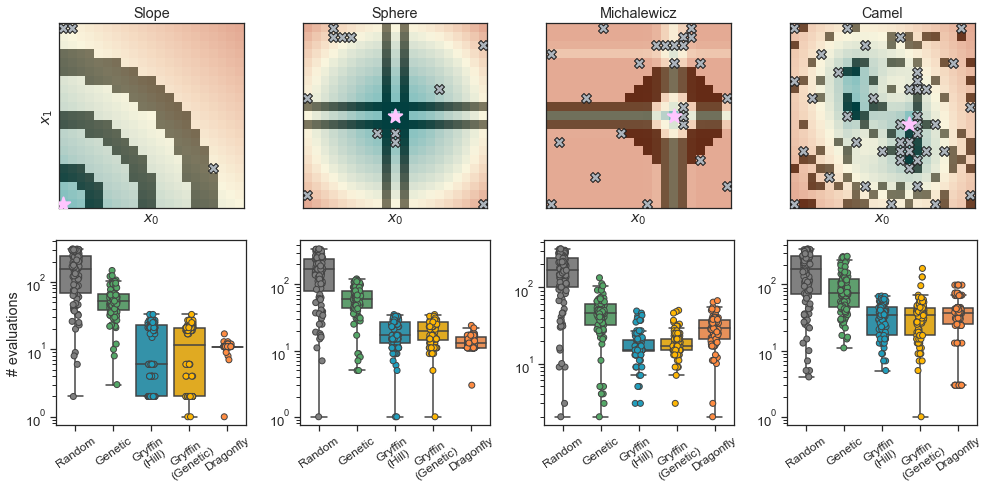

In [19]:
## PLOTS WITH LOG SCALE

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(14, 7))

# -------------
# Plot surfaces
# -------------
ax = axes[0,0]
surface = CatSlopeConstr()
plot_constr_surface_cat(surface, ax=ax, mark_min=True)
# example samples
with open('../../benchmarks_known/cat-slope/opt_adam_prior/results.pkl', 'rb') as content:
    data = pickle.load(content)
plot_cat_scatter(data, ax=ax, n=3)


ax = axes[0,1]
surface = CatDejongConstr()
plot_constr_surface_cat(surface, ax=ax, mark_min=True)
# example samples
with open('../../benchmarks_known/cat-dejong/opt_adam_prior/results.pkl', 'rb') as content:
    data = pickle.load(content)
plot_cat_scatter(data, ax=ax, n=3)


ax = axes[0,2]
surface = CatMichalewiczConstr()
plot_constr_surface_cat(surface, ax=ax, mark_min=True)
# example samples
with open('../../benchmarks_known/cat-michalewicz/opt_adam_prior/results.pkl', 'rb') as content:
    data = pickle.load(content)
plot_cat_scatter(data, ax=ax, n=8)


ax = axes[0,3]
surface = CatCamelConstr()
plot_constr_surface_cat(surface, ax=ax, mark_min=True)
# example samples
with open('../../benchmarks_known/cat-camel/opt_adam_prior/results.pkl', 'rb') as content:
    data = pickle.load(content)
plot_cat_scatter(data, ax=ax, n=0)


# -------------
# Plot boxplots
# -------------
df_slope  = plot_eval_comparison('../../benchmarks_known/cat-slope/', ax=axes[1,0], best_params=CatSlopeConstr().best, log=True)
df_dejong = plot_eval_comparison('../../benchmarks_known/cat-dejong/', ax=axes[1,1], best_params=CatDejongConstr().best, log=True)
df_michal = plot_eval_comparison('../../benchmarks_known/cat-michalewicz/', ax=axes[1,2], best_params=CatMichalewiczConstr().best, log=True)
df_camel  = plot_eval_comparison('../../benchmarks_known/cat-camel/', ax=axes[1,3], best_params=CatCamelConstr().best, log=True)

for ax in axes[1,:]:
    ax.set_xlabel('')
    ax.set_ylabel('')
#     ax.set_xticklabels([
#         'Random', 'Genetic', 'Naive Gryffin (Adam)', 
#         'Naive Gryffin (Genetic)', 'Static Gryffin (Adam)', 
#         'Static Gryffin (Genetic)' 'Dragonfly',
    
#     ], rotation=35)

    ax.set_xticklabels(['Random', 'Genetic', 
                        'Gryffin\n(Hill)', 'Gryffin\n(Genetic)', 
                        'Dragonfly'], rotation=35, 
                        fontsize=12)

for ax in axes[0,:]:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('$x_0$')
    
axes[1,0].set_ylabel('# evaluations')
axes[0,0].set_ylabel('$x_1$')
    
axes[0,0].set_title('Slope')
axes[0,1].set_title('Sphere')
axes[0,2].set_title('Michalewicz')
axes[0,3].set_title('Camel')
    
plt.tight_layout()
fig.savefig('kwn-categorical-log.pdf', bbox_inches="tight")
fig.savefig('kwn-categorical-log.png', dpi=300, bbox_inches="tight")

FOLDER :  ../../benchmarks_known/cat-slope/
11.0
0.13564659966250536
FOLDER :  ../../benchmarks_known/cat-dejong/
13.63
0.2890173005202284
FOLDER :  ../../benchmarks_known/cat-michalewicz/
29.81
1.1998912450718193
FOLDER :  ../../benchmarks_known/cat-camel/
39.0
2.3062957312539085


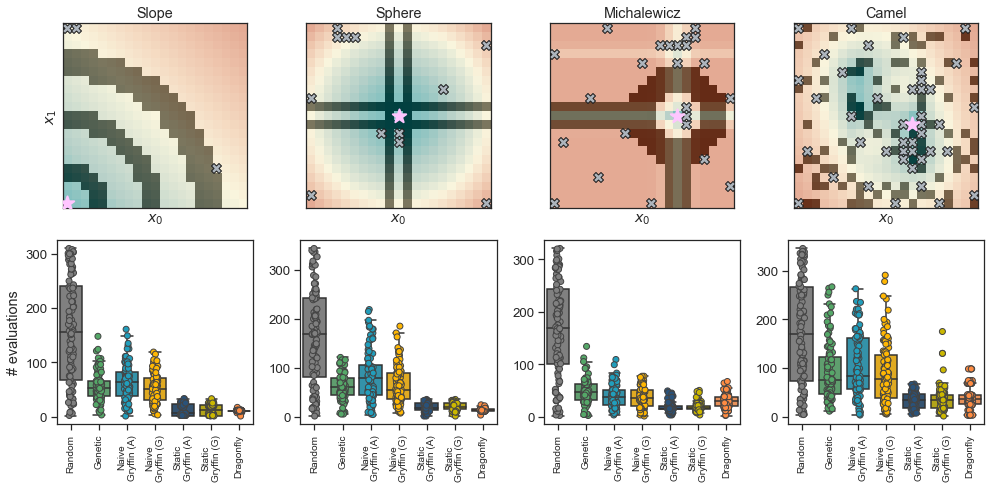

In [15]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(14, 7))

# -------------
# Plot surfaces
# -------------
ax = axes[0,0]
surface = CatSlopeConstr()
plot_constr_surface_cat(surface, ax=ax, mark_min=True)
# example samples
with open('../../benchmarks_known/cat-slope/opt_adam_prior/results.pkl', 'rb') as content:
    data = pickle.load(content)
plot_cat_scatter(data, ax=ax, n=3)


ax = axes[0,1]
surface = CatDejongConstr()
plot_constr_surface_cat(surface, ax=ax, mark_min=True)
# example samples
with open('../../benchmarks_known/cat-dejong/opt_adam_prior/results.pkl', 'rb') as content:
    data = pickle.load(content)
plot_cat_scatter(data, ax=ax, n=3)


ax = axes[0,2]
surface = CatMichalewiczConstr()
plot_constr_surface_cat(surface, ax=ax, mark_min=True)
# example samples
with open('../../benchmarks_known/cat-michalewicz/opt_adam_prior/results.pkl', 'rb') as content:
    data = pickle.load(content)
plot_cat_scatter(data, ax=ax, n=8)


ax = axes[0,3]
surface = CatCamelConstr()
plot_constr_surface_cat(surface, ax=ax, mark_min=True)
# example samples
with open('../../benchmarks_known/cat-camel/opt_adam_prior/results.pkl', 'rb') as content:
    data = pickle.load(content)
plot_cat_scatter(data, ax=ax, n=0)


# -------------
# Plot boxplots
# -------------
df_slope  = plot_eval_comparison_si('../../benchmarks_known/cat-slope/', ax=axes[1,0], best_params=CatSlopeConstr().best)
df_dejong = plot_eval_comparison_si('../../benchmarks_known/cat-dejong/', ax=axes[1,1], best_params=CatDejongConstr().best)
df_michal = plot_eval_comparison_si('../../benchmarks_known/cat-michalewicz/', ax=axes[1,2], best_params=CatMichalewiczConstr().best)
df_camel  = plot_eval_comparison_si('../../benchmarks_known/cat-camel/', ax=axes[1,3], best_params=CatCamelConstr().best)

for ax in axes[1,:]:
    ax.set_xlabel('')
    ax.set_ylabel('')
#     ax.set_xticklabels([
#         'Random', 'Genetic', 'Naive Gryffin (Adam)', 
#         'Naive Gryffin (Genetic)', 'Static Gryffin (Adam)', 
#         'Static Gryffin (Genetic)' 'Dragonfly',
    
#     ], rotation=35)

    ax.set_xticklabels(['Random', 'Genetic', 'Naive\nGryffin (A)', 'Naive\nGryffin (G)',
                        'Static\nGryffin (A)', 'Static\nGryffin (G)', 
                        'Dragonfly'], rotation=90, 
                      fontsize=10)

for ax in axes[0,:]:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('$x_0$')
    
axes[1,0].set_ylabel('# evaluations')
axes[0,0].set_ylabel('$x_1$')
    
axes[0,0].set_title('Slope')
axes[0,1].set_title('Sphere')
axes[0,2].set_title('Michalewicz')
axes[0,3].set_title('Camel')
    
plt.tight_layout()
fig.savefig('kwn-categorical-si-full.pdf', bbox_inches="tight")
fig.savefig('kwn-categorical-si-full.png', dpi=300, bbox_inches="tight")

In [12]:
#  examine the extent of parameter duplication for dragonfly

df_dragon = df_slope[df_slope['opt_strategy']=='dragonfly']
max(df_dragon['num_evals'])

72

In [14]:
data_dragon_0 = pickle.load(open(f'../../benchmarks_known/cat-camel/dragonfly_0/results.pkl', 'rb'))
data_dragon_1 = pickle.load(open(f'../../benchmarks_known/cat-camel/dragonfly_1/results.pkl', 'rb'))
data_dragon_2 = pickle.load(open(f'../../benchmarks_known/cat-camel/dragonfly_2/results.pkl', 'rb'))
data_dragon_3 = pickle.load(open(f'../../benchmarks_known/cat-camel/dragonfly_3/results.pkl', 'rb'))
data_dragon_4 = pickle.load(open(f'../../benchmarks_known/cat-camel/dragonfly_4/results.pkl', 'rb'))
len(data_dragon_0), len(data_dragon_1), len(data_dragon_2), len(data_dragon_3), len(data_dragon_4),

(20, 20, 20, 20, 20)

In [38]:
#unpack_dragonfly(path='../../benchmarks_known/cat-camel/', )
surf = CatCamelConstr()
surf.best
#surf.run(['x_7', 'x_14'])

('x_13', 'x_9')

In [31]:
drag_res = unpack_dragonfly(path='../../benchmarks_known/cat-camel/', best_params=CatCamelConstr().best)
drag_res

array([349,  14,  34, 349, 349,  28,  42,   4, 349, 349, 349, 109,  31,
        68, 349,  37,  57, 349,  12, 349, 349,  14,  34, 349, 349,  28,
        42,   4, 349, 349, 349, 109,  31,  68, 349,  37,  57, 349,  12,
       349, 349,  14,  34, 349, 349,  28,  42,   4, 349, 349, 349, 109,
        31,  68, 349,  37,  57, 349,  12, 349, 349,  14,  34, 349, 349,
        28,  42,   4, 349, 349, 349, 109,  31,  68, 349,  37,  57, 349,
        12, 349, 349,  14,  34, 349, 349,  28,  42,   4, 349, 349, 349,
       109,  31,  68, 349,  37,  57, 349,  12, 349])

In [37]:
d = pickle.load(open(f'../../benchmarks_known/cat-camel/dragonfly_0/results.pkl', 'rb'))
d[3]

,x0,x1,obj
0,x_6,x_17,-6.517303
1,x_6,x_19,-8.522948
2,x_0,x_19,-12.212859
3,x_4,x_17,-8.176438
4,x_18,x_18,-12.297462
...,...,...,...
343,x_7,x_13,-4.011669
344,x_7,x_14,-3.763322
345,x_7,x_14,-3.763322
346,x_7,x_14,-3.763322
